In [1]:
import sys
sys.path.append('../..')

In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from DomainPrediction.utils import helper

In [4]:
data_path = '../../../Data/al_test_experiments/GB1'

In [5]:
df_train = pd.read_pickle(os.path.join(data_path, 'train.pkl'))
df_val = pd.read_pickle(os.path.join(data_path, 'valid.pkl'))
df_test = pd.read_pickle(os.path.join(data_path, 'test.pkl'))

In [6]:
df_train.head()

,primary,gb1_score,gb1_score_extra,gb1_score_str
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,<extra_id_1><extra_id_20><extra_id_0>,1.00
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,<extra_id_1><extra_id_20><extra_id_4><extra_i...,1.45
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,<extra_id_1><extra_id_20><extra_id_6><extra_i...,1.69
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,<extra_id_1><extra_id_20><extra_id_1><extra_i...,1.17
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,<extra_id_2><extra_id_20><extra_id_4>,2.40


In [7]:
wt = helper.read_fasta(os.path.join(data_path, 'GB1_WT.fasta'), mode='str')[0]

In [9]:
## sanity check againts wildtype len
for _df in [df_train, df_val, df_test]:
    for i, row in _df.iterrows():
        assert len(wt) == len(row['primary'])

In [10]:
df_train['split_id'] = 2
df_val['split_id'] = 1
df_test['split_id'] = 0

In [13]:
df = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

In [14]:
df.head()

,primary,gb1_score,gb1_score_extra,gb1_score_str,split_id
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,<extra_id_1><extra_id_20><extra_id_0>,1.00,2
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,<extra_id_1><extra_id_20><extra_id_4><extra_i...,1.45,2
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,<extra_id_1><extra_id_20><extra_id_6><extra_i...,1.69,2
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,<extra_id_1><extra_id_20><extra_id_1><extra_i...,1.17,2
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,<extra_id_2><extra_id_20><extra_id_4>,2.40,2


In [16]:
df_new = df[['primary', 'gb1_score', 'split_id']].copy()
df_new.columns = ['seq', 'fitness_raw', 'split_id']

In [17]:
df_new.head()

,seq,fitness_raw,split_id
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2


In [20]:
n_muts = []
for i, row in df_new.iterrows():
    variant_seq = row["seq"]
    assert len(variant_seq) == len(wt)
    n = 0
    for a, b in zip(variant_seq, wt):
        if a != b:
            n += 1
    
    n_muts.append(n)

df_new['n_mut'] = n_muts

In [21]:
df_new.head()

,seq,fitness_raw,split_id,n_mut
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.00,2,0
1,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIDGEWTYD...,1.45,2,1
2,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGLDGEWTYD...,1.69,2,1
3,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMDGEWTYD...,1.17,2,1
4,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVAGEWTYD...,2.40,2,1


In [22]:
df_new['n_mut'].unique()

array([0, 1, 2, 3, 4])

In [26]:
from collections import Counter

In [27]:
for split in df_new['split_id'].unique():
    temp = df_new.loc[df_new['split_id']==split, 'n_mut'].unique()
    print(f'n mutation for split {split}: {temp}')
    print(Counter(df_new.loc[df_new['split_id']==split, 'n_mut']))

n mutation for split 2: [0 1 2 3]
Counter({3: 2307, 2: 360, 1: 23, 0: 1})
n mutation for split 1: [1 2 3]
Counter({3: 259, 2: 36, 1: 4})
n mutation for split 0: [4]
Counter({4: 5743})


In [68]:
temp = []
for x in df_new['fitness_raw']:
    if x == 0:
        temp.append(1e-6)
    else:
        temp.append(x)

In [69]:
df_new['fitness_log'] = np.log(temp)

In [70]:
file = os.path.join(data_path, 'dataset_gb1.csv')
df_new.to_csv(file, index=False)

In [71]:
file = os.path.join(data_path, 'dataset_gb1.csv')
df_new = pd.read_csv(file)

Text(0.5, 1.0, 'Test')

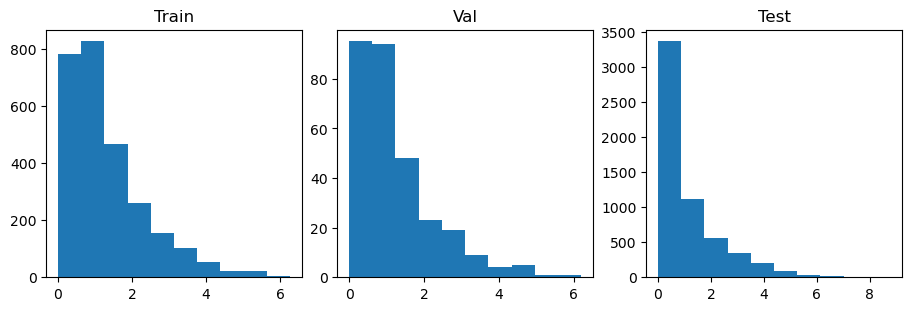

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_raw'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_raw'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_raw'])
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

Text(0.5, 1.0, 'Test')

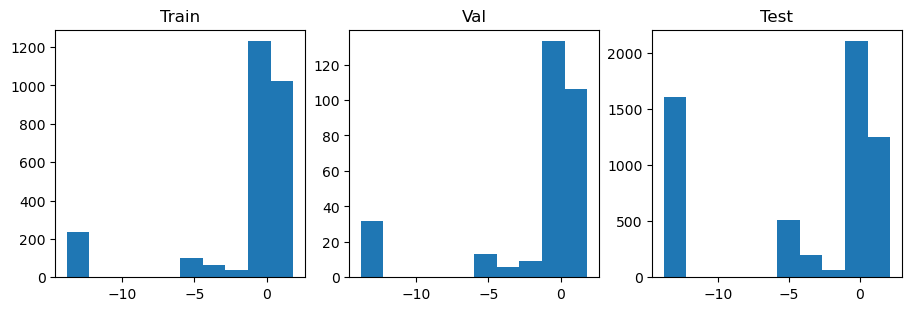

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(9,3), layout='constrained')
ax[0].hist(df_new.loc[df_new['split_id']==2, 'fitness_log'])
ax[1].hist(df_new.loc[df_new['split_id']==1, 'fitness_log'])
ax[2].hist(df_new.loc[df_new['split_id']==0, 'fitness_log'])
ax[0].set_title('Train')
ax[1].set_title('Val')
ax[2].set_title('Test')

In [74]:
df_new['n_mut'].unique()

array([0, 1, 2, 3, 4])

In [75]:
df_new[df_new['n_mut']==0]

,seq,fitness_raw,split_id,n_mut,fitness_log
0,MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYD...,1.0,2,0,0.0


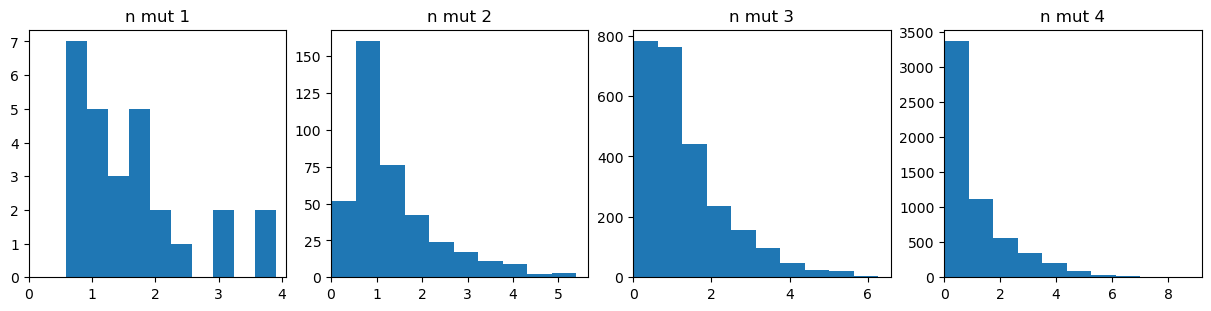

In [79]:
fig, ax = plt.subplots(1, 4, figsize=(12,3), layout='constrained')
for i, n_mut in enumerate([1, 2, 3, 4]):
    ax[i].hist(df_new.loc[df_new['n_mut']==n_mut, 'fitness_raw'])
    ax[i].set_title(f'n mut {n_mut}')
    ax[i].set_xlim(left=0)

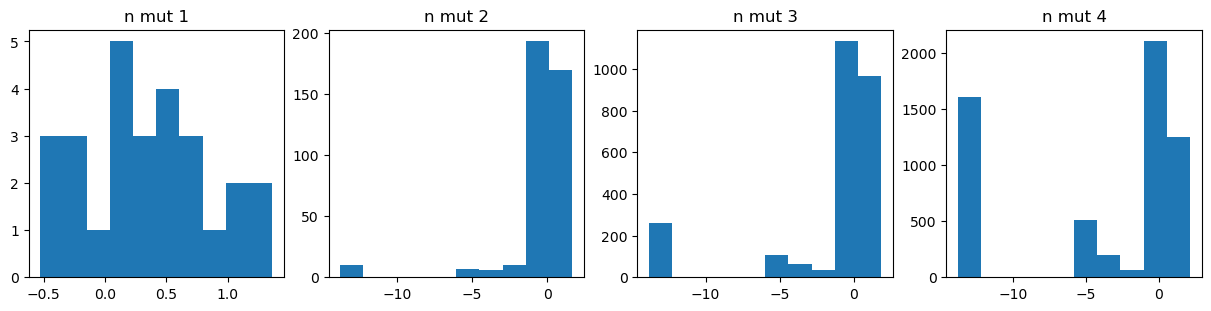

In [81]:
fig, ax = plt.subplots(1, 4, figsize=(12,3), layout='constrained')
for i, n_mut in enumerate([1, 2, 3, 4]):
    ax[i].hist(df_new.loc[df_new['n_mut']==n_mut, 'fitness_log'])
    ax[i].set_title(f'n mut {n_mut}')